In [4]:
# -*- coding: utf-8 -*-

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pickle
from collections import Counter

# load the graph
G = nx.read_gexf("mediumLinkedin.gexf")

# load the profiles. 3 files for each type of attribute
# Some nodes in G have no attributes
# Some nodes may have 1 attribute 'location'
# Some nodes may have 1 or more 'colleges' or 'employers', so we
# use dictionaries to store the attributes
college = {}
location = {}
employer = {}
# The dictionaries are loaded as dictionaries from the disk (see pickle in Python doc)
with open('mediumCollege_60percent_of_empty_profile.pickle', 'rb') as handle:
    college = pickle.load(handle)
with open('mediumLocation_60percent_of_empty_profile.pickle', 'rb') as handle:
    location = pickle.load(handle)
with open('mediumEmployer_60percent_of_empty_profile.pickle', 'rb') as handle:
    employer = pickle.load(handle)
# here are the empty nodes for whom your challenge is to find the profiles
empty_nodes = []
with open('mediumRemovedNodes_60percent_of_empty_profile.pickle', 'rb') as handle:
    empty_nodes = pickle.load(handle)

i = 0
for n in G:
    if len(list(G[n])) == 0:
        i += 1

In [5]:
print("Nb of users in our graph: %d" % len(G))
print("Nb of users with one or more attribute college: %d" % len(college))
print("Nb of users with one or more attribute location: %d" % len(location))
print("Nb of users with one or more attribute employer: %d" % len(employer))
print("Your mission, find attributes to %d users with empty profile" % len(empty_nodes))
print('isolated nodes number = ' + str(i))


Nb of users in our graph: 811
Nb of users with one or more attribute college: 230
Nb of users with one or more attribute location: 336
Nb of users with one or more attribute employer: 297
Your mission, find attributes to 475 users with empty profile
isolated nodes number = 0


In [6]:
def drawGraph(g,color = True):
    print('drawing the Graph, be patient please ^-^')
    plt.figure(num=None, figsize=(30, 30), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(g, iterations=100)
    if color == True:
        node_colors = [g.node[v]['color'] for v in g]
        nx.draw_networkx(g,node_color = node_colors)
    elif color == False:
        nx.draw_networkx(g)
    plt.show()

In [32]:
# Mesure the accuracy function
def evaluation_accuracy(groundtruth, pred):
    true_positive_prediction = 0
    for p_key, p_value in pred.items():
        if p_key in groundtruth:
            # if prediction is no attribute values, e.g. [] and so is the groundtruth
            # May happen
            if not p_value and not groundtruth[p_key]:
                true_positive_prediction += 1
            # counts the number of good prediction for node p_key
            # here len(p_value)=1 but we could have tried to predict more values
            true_positive_prediction += len([c for c in p_value if c in groundtruth[p_key]])
            # no else, should not happen: train and test datasets are consistent
    return true_positive_prediction*100/sum(len(v) for v in pred.values())

In [8]:
# Test function which use The evaluation_accuracy function
def testLocation(location_prediction):
    groundtruth = {}
    with open('mediumLocation.pickle', 'rb') as handle:
        groundtruth_location = pickle.load(handle)
    result = evaluation_accuracy(groundtruth_location, location_prediction)
    print('\n print the groudtruth rate for location_prediction')
    print("%f%% of the predictions are true" % result)
    return result
# test college
def testCollege(college_prediction):
    groundtruth = {}
    with open('mediumcollege.pickle', 'rb') as handle:
        groundtruth_college = pickle.load(handle)
    result = evaluation_accuracy(groundtruth_college, college_prediction)
    print('\n print the groudtruth rate for college_prediction')
    print("%f%% of the predictions are true" % result)
    return result
# test employer
def testEmployer(employer_prediction):
    groundtruth = {}
    with open('mediumEmployer.pickle', 'rb') as handle:
        groundtruth_employer = pickle.load(handle)
    result = evaluation_accuracy(groundtruth_employer, employer_prediction)
    print('\n print the groudtruth rate for EmployerPrediction')
    print("%f%% of the predictions are true" % result)
    return result

In [9]:
### Prediction by biggest degree neighbor 1
def prediction_by_ngb_degree(dict1,g=G, test=empty_nodes):
    prediction_dict = {}
    for n in test:
        ngbs = g[n]
        degreeMax = 0
        for ngb in ngbs:
            if g.degree(ngb) > degreeMax:
                degreeMax = g.degree(ngb)
                aime = ngb
        if ngb in dict1.keys():
            prediction_dict[n] = dict1[ngb]
    return prediction_dict

def prediction_by_ngb_degree2(dict1,g=G, test=empty_nodes):
    prediction_dict = {}
    degrees = [(g.degree(n),n) for n in g]
    degrees = sorted(degrees,reverse=True)
    degrees = np.array(degrees)
    
    for n in test:
        ngbs = g[n]
        degreeMax = 0
        for ngb in ngbs:
            if ngb in degrees[:2,1] and g.degree(ngb) > degreeMax :
                degreeMax = g.degree(ngb)
                aime = ngb
        if ngb in dict1.keys():
            prediction_dict[n] = dict1[ngb]
    return prediction_dict

In [41]:
# Prediction by the most frequent attribut
def naive_method(attr,graph, empty):
    predicted_values={}
    for n in empty:
        nbrs_attr_values=[] 
        for nbr in graph.neighbors(n):
            if nbr in attr:
                for val in attr[nbr]:
                    nbrs_attr_values.append(val)
        predicted_values[n]=[]
        if nbrs_attr_values: # non empty list
            cpt=Counter(nbrs_attr_values)
            a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
            predicted_values[n].append(a)
    return predicted_values

In [47]:
# Prediction By the biggest cluster 
def prediction_by_cluster(attr,cluster_coef = 0.5,test=empty_nodes,g=G):
    #clustering analyse
    partial_clustering = nx.clustering(g)
#     print(partial_clustering)
    clusteringGroups = {}
    for pc_key in partial_clustering:
        pc_val = partial_clustering[pc_key]
        if pc_val >= cluster_coef:
            clusteringGroups[pc_key] = pc_val
    
    new_empty = []
    new_empty2 = []
    for n in test:
        for m in g[n]:
            if m in clusteringGroups and n not in new_empty:
                new_empty.append(n)
    for n in test:
        if n not in new_empty:
            new_empty2.append(n)
    
    dict1 = naive_method(attr,g,new_empty)
    at = attr
    at.update(dict1)
    dict2 = prediction_by_ngb_degree(attr,g,new_empty2)
    
    dict3 = dict(dict2)
    dict3.update(dict1)
    
    return dict3

In [42]:
# Results for the naive method
proba = testLocation(naive_method(location,G,empty_nodes))
proba = testCollege(naive_method(college,G,empty_nodes))
proba = testEmployer(naive_method(employer,G,empty_nodes))


 print the groudtruth rate for location_prediction
31.355932% of the predictions are true

 print the groudtruth rate for college_prediction
24.889868% of the predictions are true

 print the groudtruth rate for EmployerPrediction
20.833333% of the predictions are true


In [13]:
# test begin bigges DEGREE
proba = testLocation(prediction_by_ngb_degree(location))
proba = testCollege(prediction_by_ngb_degree(college))
proba = testEmployer(prediction_by_ngb_degree(employer))


 print the groudtruth rate for location_prediction
24.113475% of the predictions are true

 print the groudtruth rate for college_prediction
13.227513% of the predictions are true

 print the groudtruth rate for EmployerPrediction
8.352144% of the predictions are true


In [14]:
# Result for the clustering prediction
proba = testLocation(prediction_by_cluster(location,0.68))
proba = testCollege(prediction_by_cluster(college,0.6))
proba  = testEmployer(prediction_by_cluster(employer,0.8))


 print the groudtruth rate for location_prediction
30.143541% of the predictions are true

 print the groudtruth rate for college_prediction
23.326134% of the predictions are true

 print the groudtruth rate for EmployerPrediction
14.467409% of the predictions are true


In [15]:
def strMatch(str1,attr):
    string_matched = []
    key_matched = []
    for n in attr:
        for m in attr[n]:
            if m.find(str1)<0:
                continue
            else:
                string_matched.append(m)
                if n not in key_matched:
                    key_matched.append(n)
    return string_matched,key_matched            


# Find the most top 5 influencable users in Bay Area


 print the groudtruth rate for location_prediction
30.585683% of the predictions are true
pagerank top 5
['U27287', 'U7024', 'U22747', 'U27603', 'U27532']
influence top 5
[(6.835140997830802, 'U27287'), (4, 'U7024'), (2.6117136659436007, 'U22747'), (2, 'U8670'), (2, 'U11566')]
drawing the Graph, be patient please ^-^


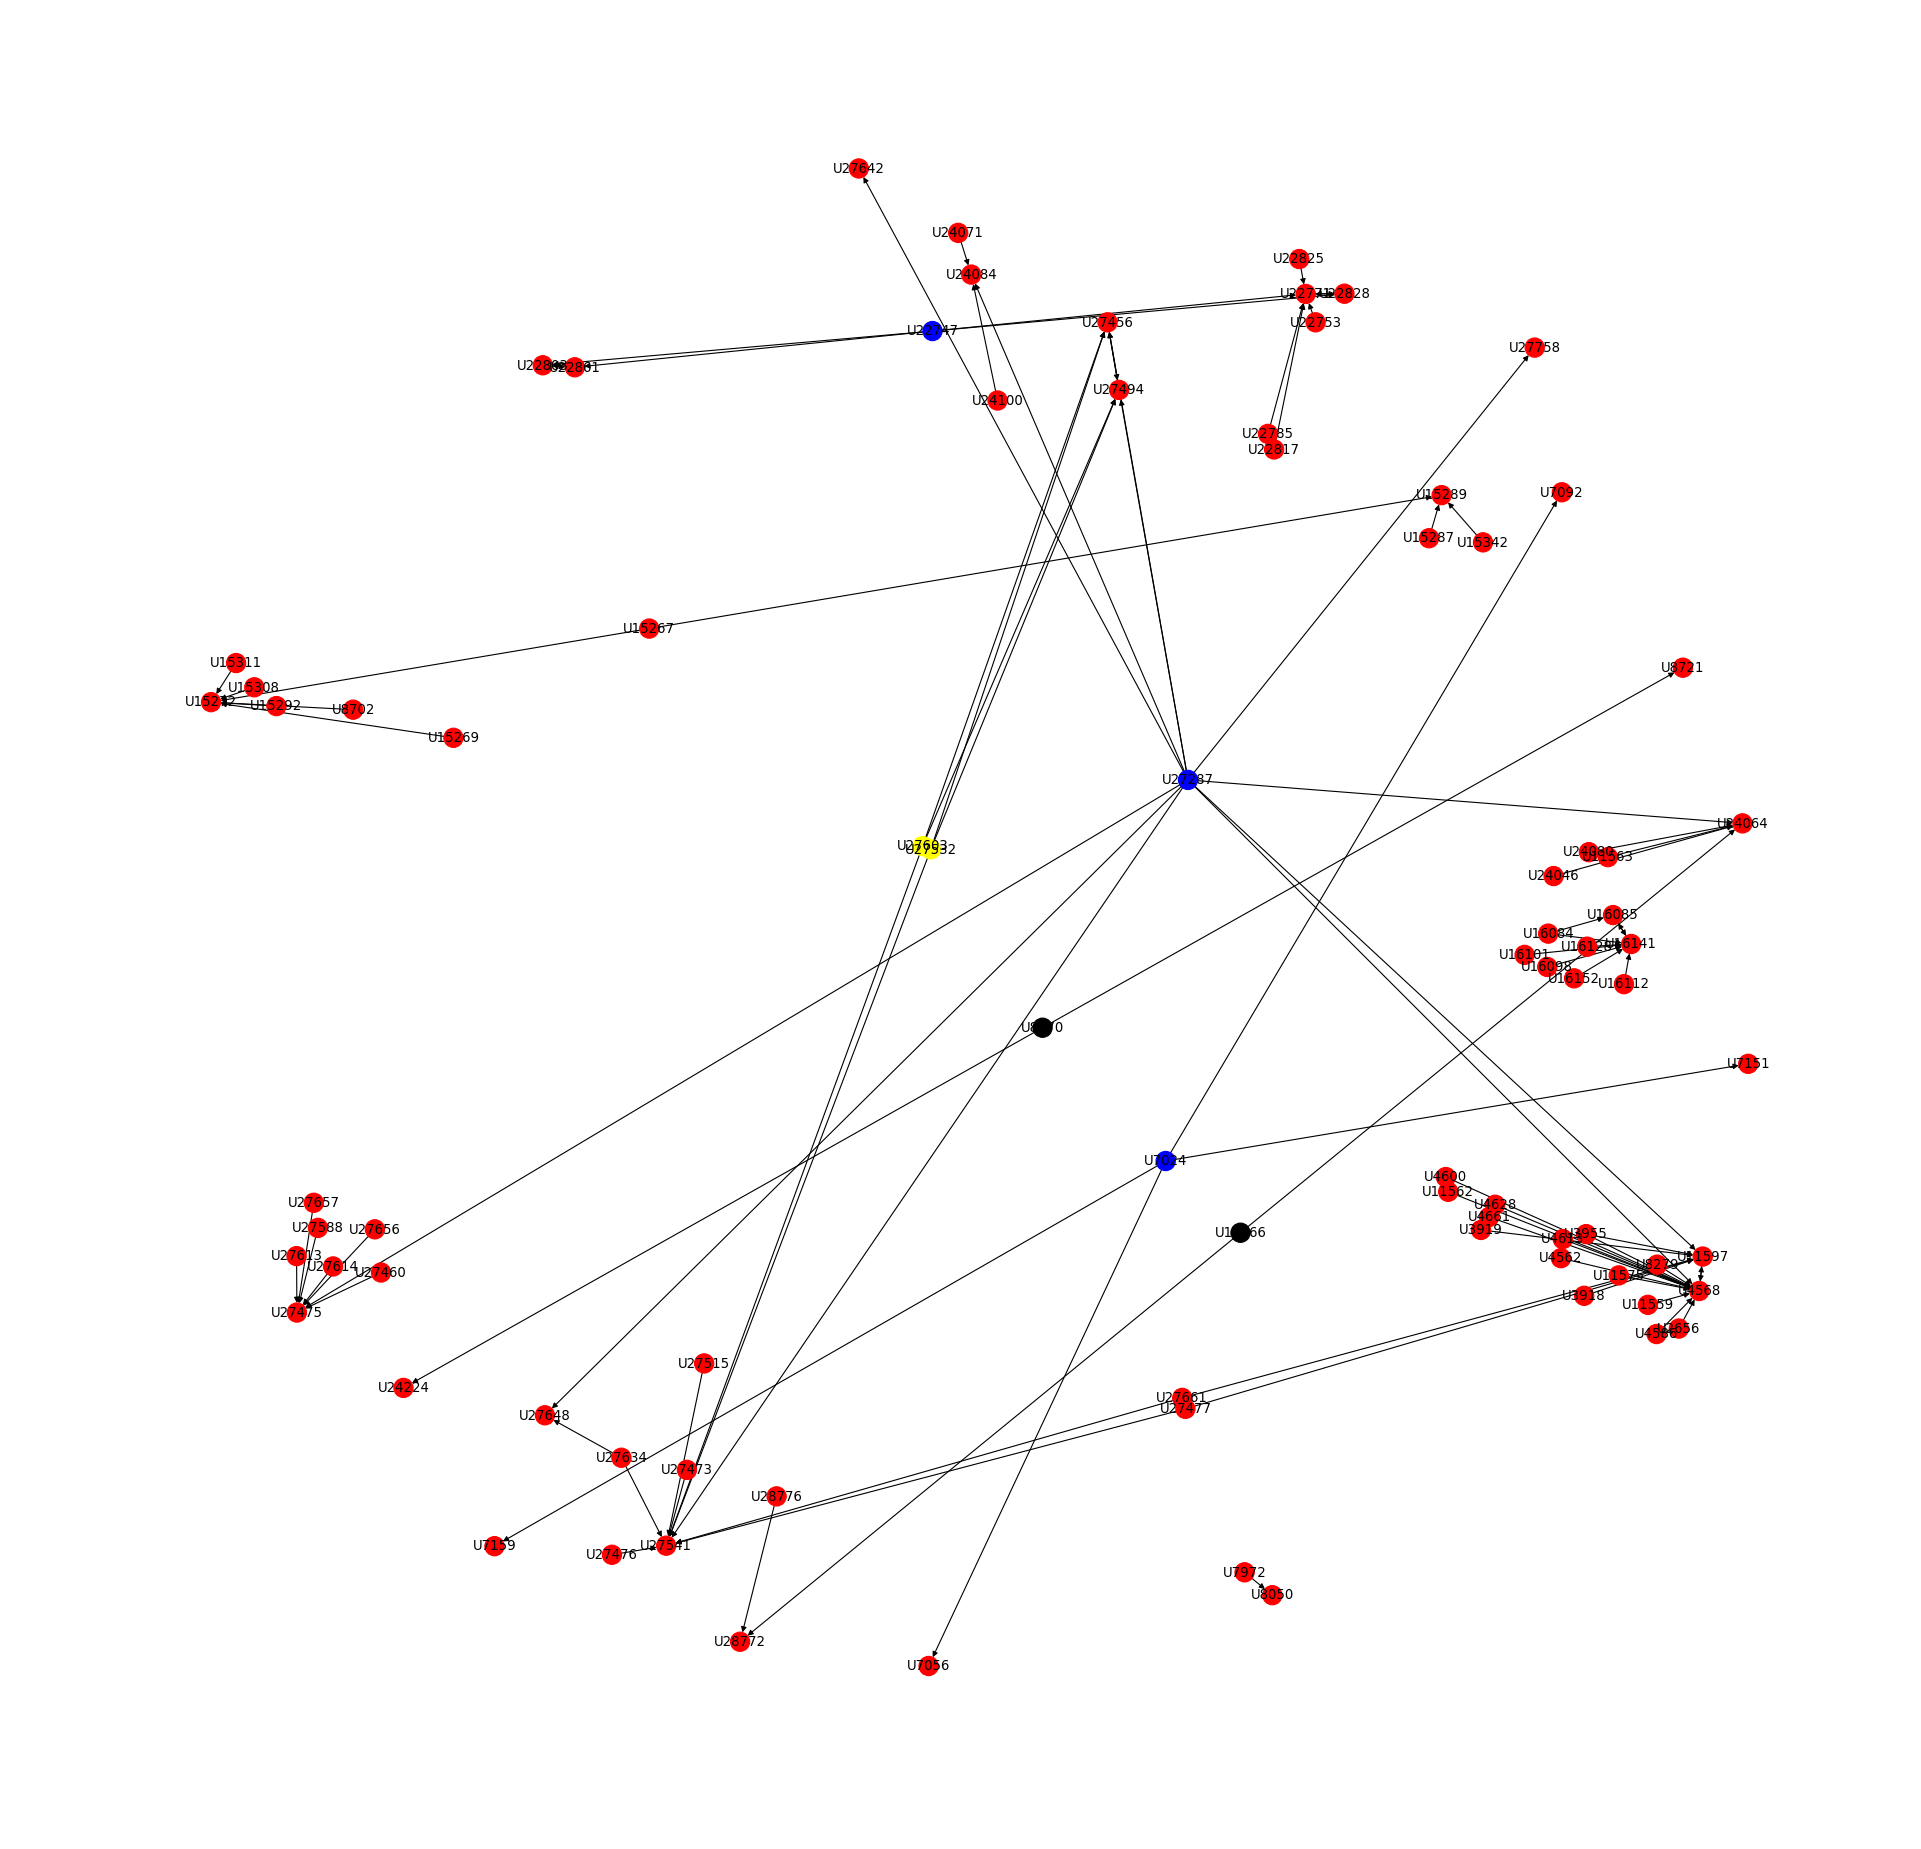

In [16]:
# full-fill the missing value and make a new graph for the Bay Area

prediction_location = naive_method(G,empty_nodes,location)

proba_prediction = testLocation(prediction_location)/100

dic1 = location
dic1.update(prediction_location)
emp_noValues = []
for n in G:
    if n not in prediction_location or n not in location:
        emp_noValues.append(n)


prediction_location_for_novalues = naive_method(G,emp_noValues,dic1)

prediction_location.update(prediction_location_for_novalues)

loc_matched,loc_key_matched = strMatch('bay',location)
loc_matched_pred,loc_key_matched_pred = strMatch('bay',prediction_location)
loc_key_all = loc_key_matched + loc_key_matched_pred
edges = []
G_Bay = nx.DiGraph()

influence_matrix = {}

for i in G:
    influence_matrix[i] = 0
for k in G:
    for ngb in G[k]:
        if ngb in loc_key_matched and ngb not in loc_key_matched_pred:
            edges.append((k,ngb,{'weight':1}))
            influence_matrix[k] += 1
        elif ngb not in loc_key_matched and ngb in loc_key_matched_pred:
            edges.append((k,ngb,{'weight':proba_prediction}))
            influence_matrix[k] += proba_prediction
G_Bay.add_edges_from(edges)

influence_list = [(j,i) for i,j in influence_matrix.items()]
influence_list = sorted(influence_list, reverse = True)

pr = {}
pr1 = {}
for i in G_Bay:
    pr[i] = G_Bay.out_degree(i)

pr_list = [(n_val,n_key) for n_key,n_val in pr.items()]
pr_list = sorted(pr_list,reverse= True)

vals = {}
keys = []
a = 5
for i in range(0,a):
    vals[pr_list[i][1]] = float(pr_list[i][0])
    keys.append(pr_list[i][1])
    G_Bay.node[pr_list[i][1]]['color'] = 'yellow'
print('pagerank top 5')
print(keys)
for i in range(a,len(G_Bay)):
    vals[pr_list[i][1]] = float(pr_list[i][0])
    keys.append(pr_list[i][1])
    G_Bay.node[pr_list[i][1]]['color'] = 'red'
    
for i in range(a):
    if influence_list[i][1] in G_Bay.nodes() and G_Bay.node[influence_list[i][1]]['color'] == 'yellow':
        G_Bay.node[influence_list[i][1]]['color'] = 'blue'
    elif influence_list[i][1] in G_Bay.nodes() and G_Bay.node[influence_list[i][1]]['color'] != 'yellow':
        G_Bay.node[influence_list[i][1]]['color'] = 'black'
    elif influence_list[i][1] not in G_Bay.nodes():
        print(influence_list[i])
print('influence top 5')
print(influence_list[:5])

drawGraph(G_Bay)

['U27287', 'U7024', 'U11566', 'U3955', 'U27475']
[(6.835140997830802, 'U27287'), (4, 'U7024'), (2.6117136659436007, 'U22747'), (2, 'U8670'), (2, 'U11566')]
drawing the Graph, be patient please ^-^


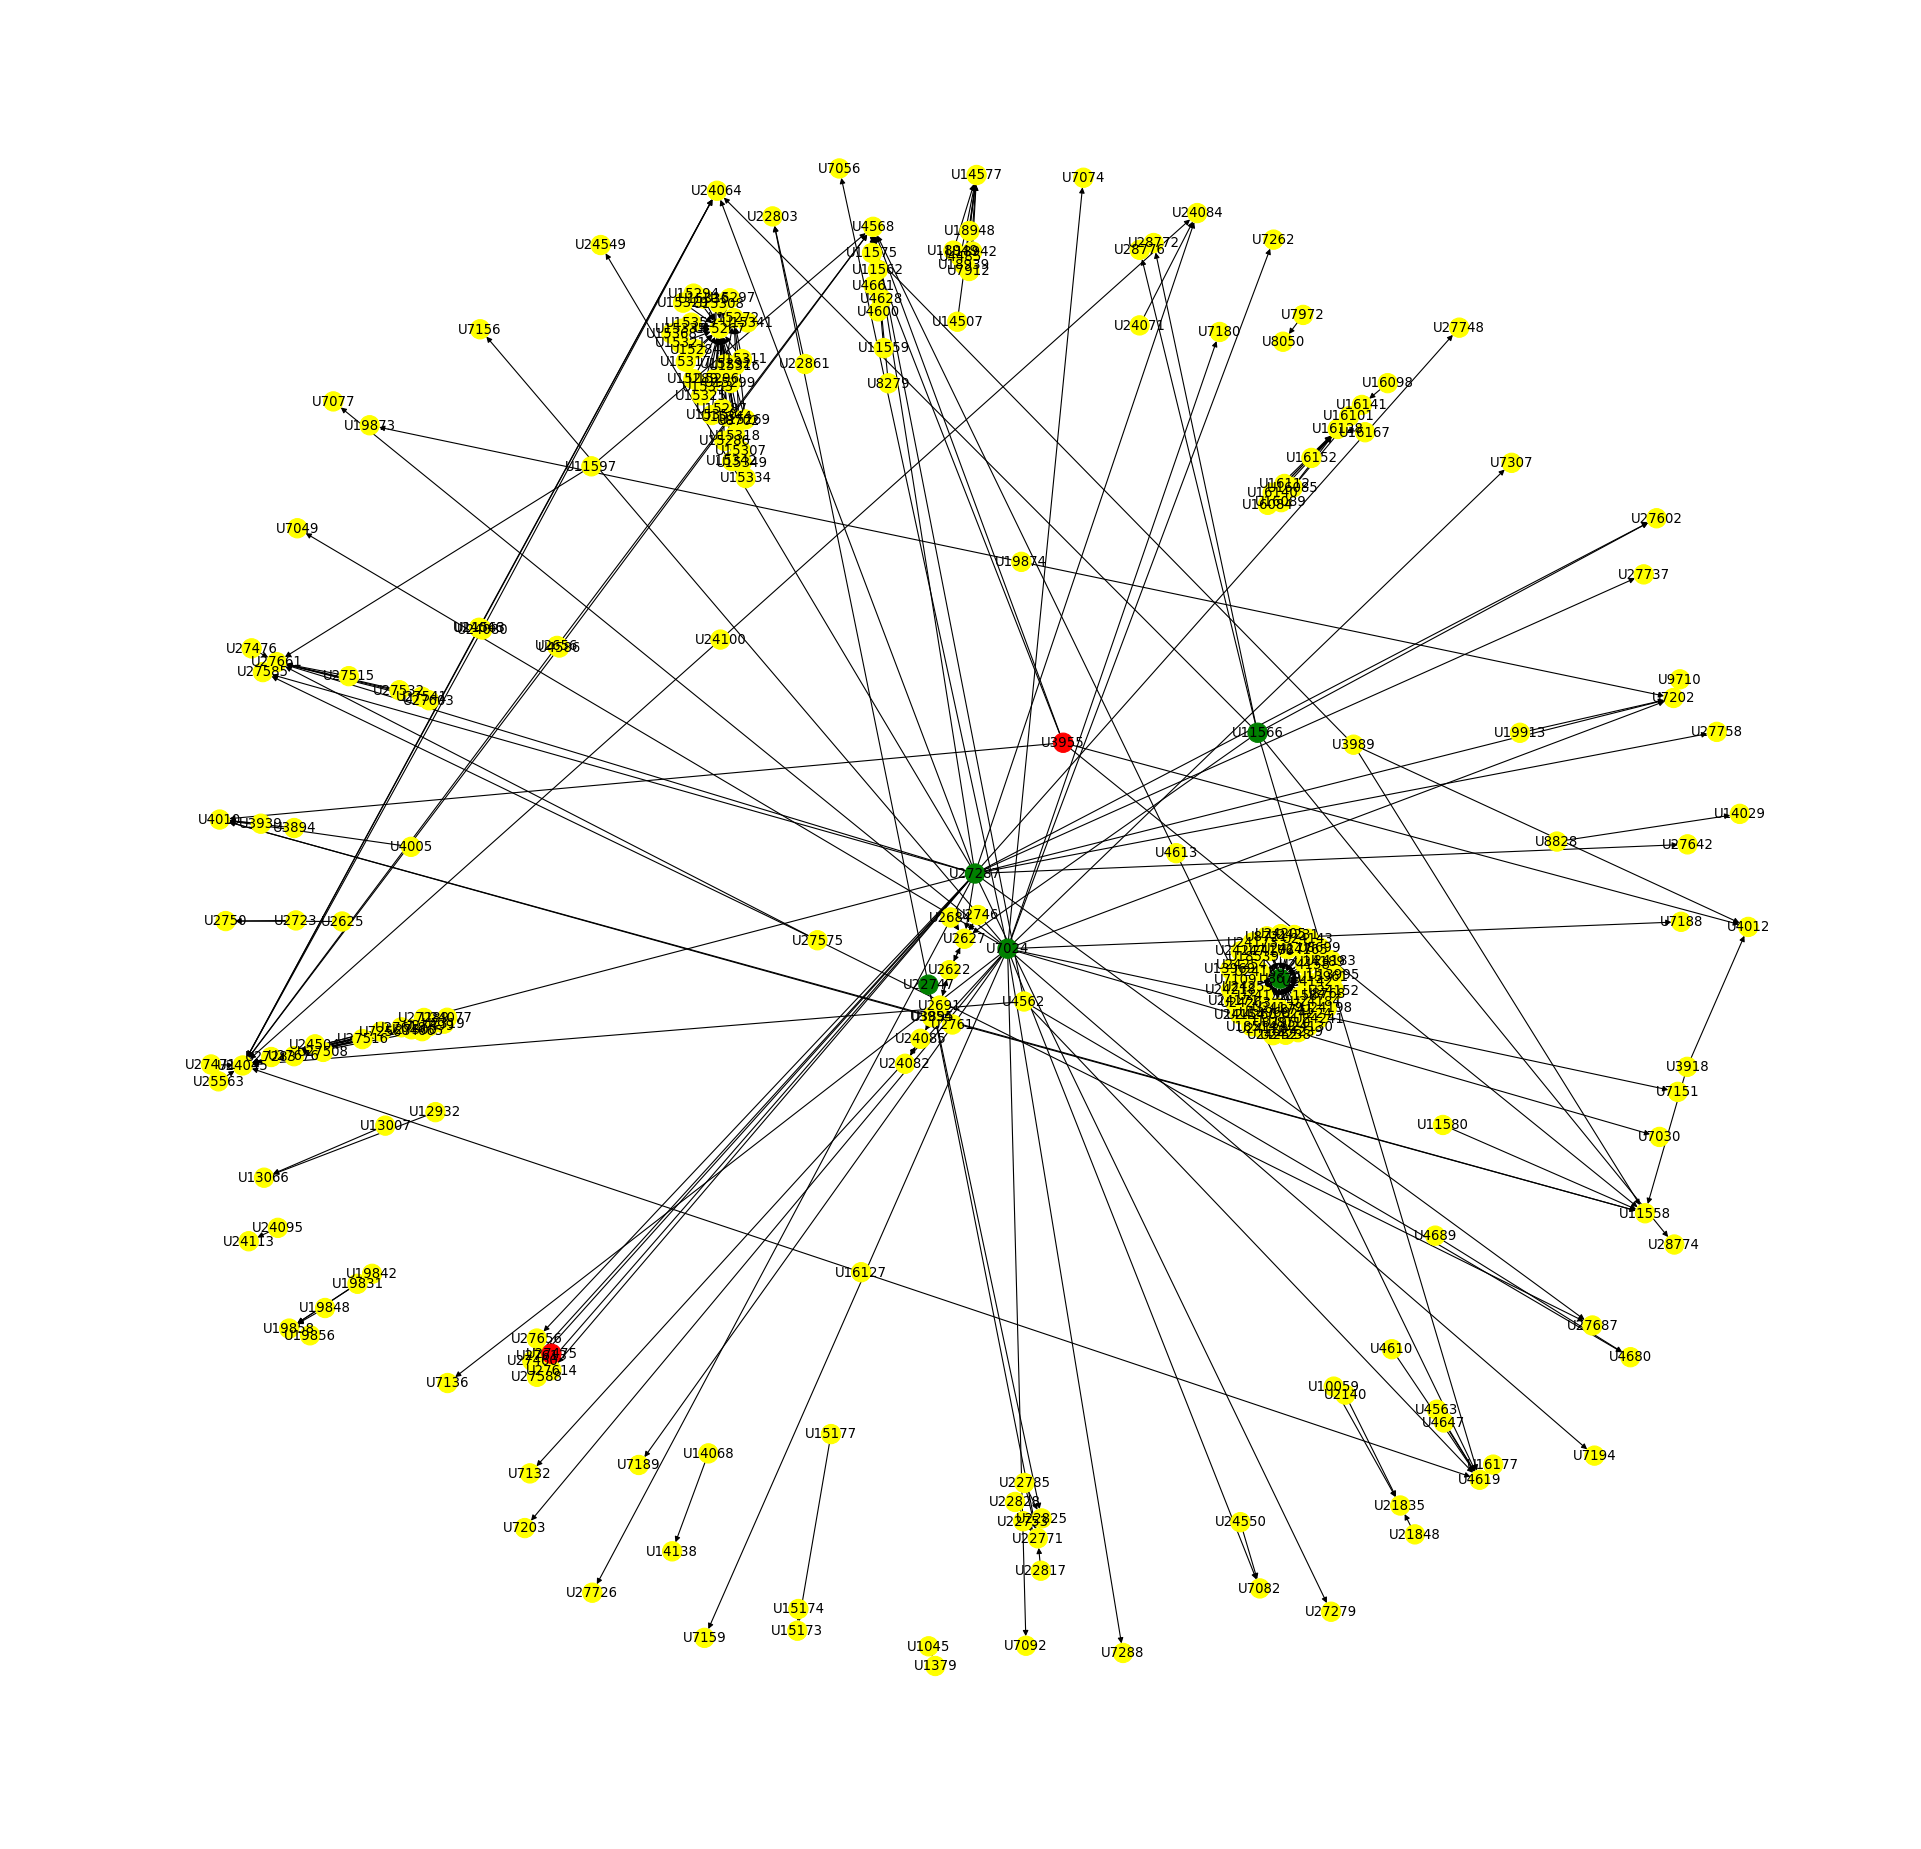

In [17]:
# Test with the real data 
with open('mediumlocation.pickle', 'rb') as handle:
    groundtruth_location = pickle.load(handle)
real_loc_matched,real_loc_key_matched = strMatch('bay',groundtruth_location)
edges = []
G_Bay_real = nx.DiGraph()

for k in G:
    for ngb in G[k]:
        if ngb in real_loc_key_matched:
            edges.append((k,ngb,{'weight':1}))
G_Bay_real.add_edges_from(edges)
pr = {}
for i in G_Bay_real:
    pr[i] = G_Bay_real.out_degree(i)
pr_list = [(n_val,n_key) for n_key,n_val in pr.items()]
pr_list = sorted(pr_list,reverse= True)

real_vals = {}
real_keys = []
alpha = 5
for i in range(0,alpha):
    real_vals[pr_list[i][1]] = float(pr_list[i][0])
    real_keys.append(pr_list[i][1])
    G_Bay_real.node[pr_list[i][1]]['color'] = 'red'
print(real_keys)
for i in range(alpha,len(G_Bay_real)):
    real_vals[pr_list[i][1]] = float(pr_list[i][0])
    real_keys.append(pr_list[i][1])
    G_Bay_real.node[pr_list[i][1]]['color'] = 'yellow'

l2 = influence_list[:5]   
print(l2)
for i in l2:
    i = i[1]
    if i in real_keys and i in G_Bay_real:
        G_Bay_real.node[i]['color'] = 'green'
    else:
        G_Bay_real.node[i]['color'] = 'blue'
    
drawGraph(G_Bay_real)

['U8670', 'U15267', 'U15272', 'U8721', 'U24224']
drawing the Graph, be patient please ^-^


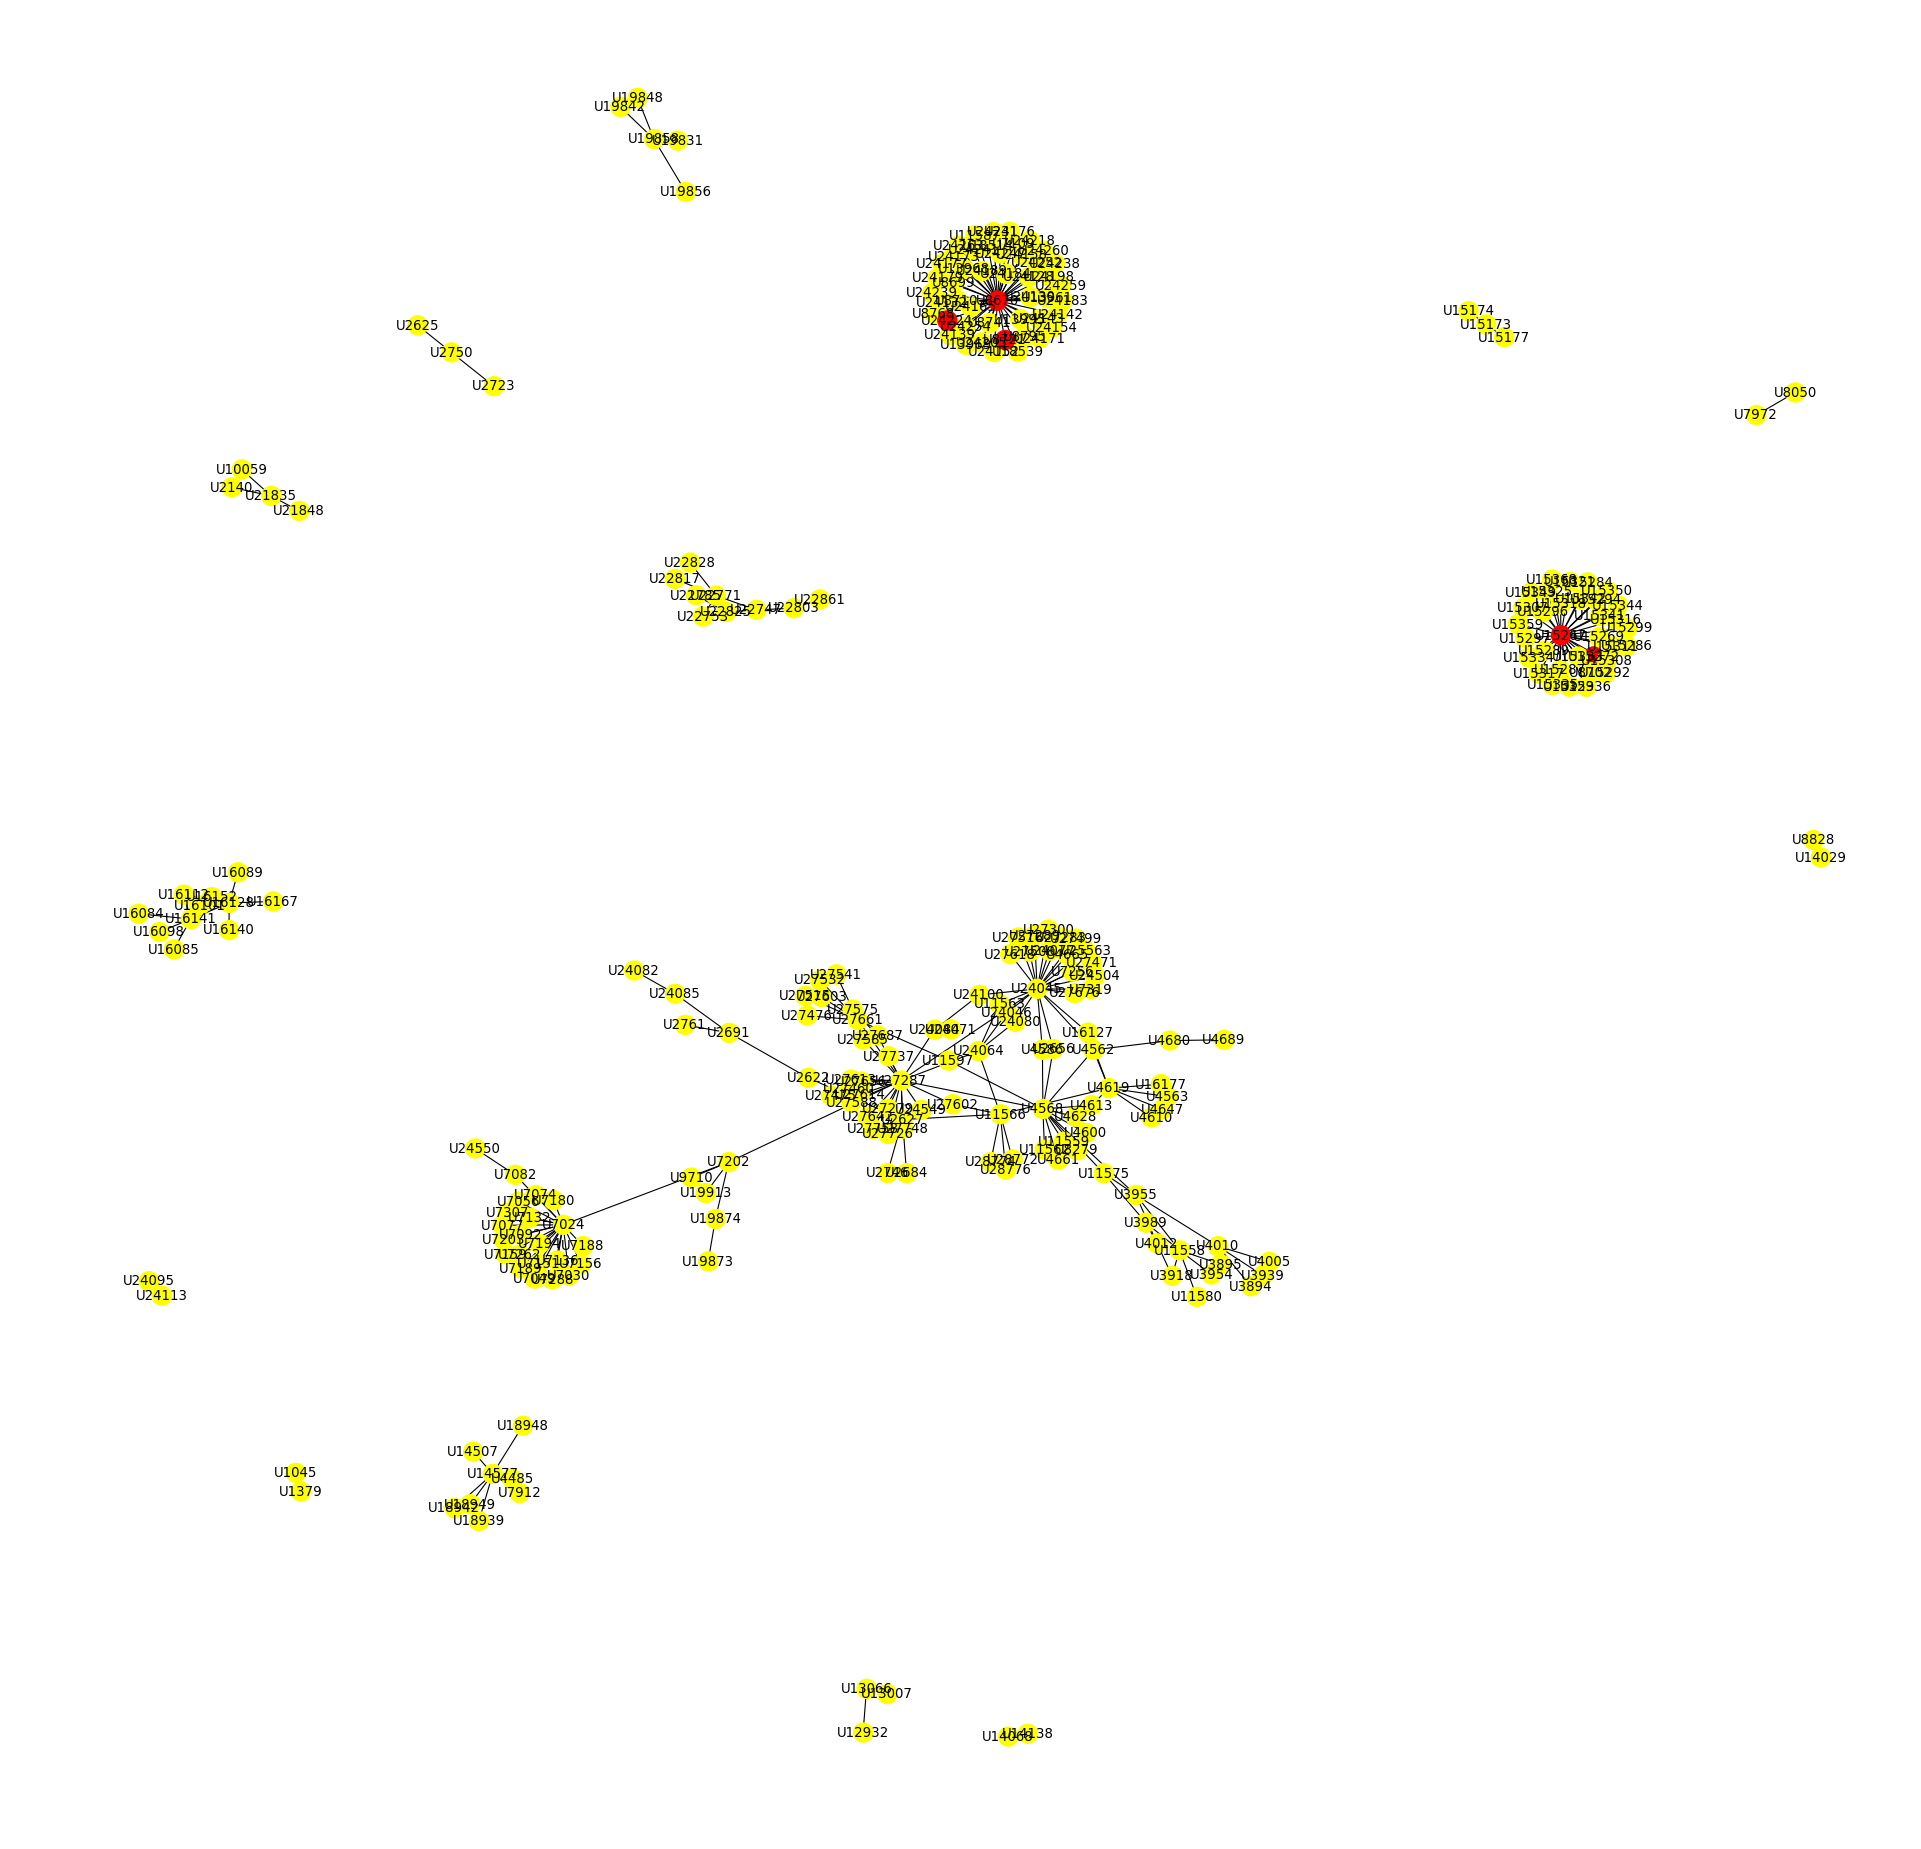

In [18]:
# Test with the real data 
real_loc_matched,real_loc_key_matched = strMatch('bay',groundtruth_location)
edges = []
G_Bay_real1 = nx.Graph()

for k in G:
    for ngb in G[k]:
        if ngb in real_loc_key_matched:
            edges.append((k,ngb,{'weight':1}))
G_Bay_real1.add_edges_from(edges)

pr = nx.algorithms.pagerank(G_Bay_real)
pr_list = [(n_val,n_key) for n_key,n_val in pr.items()]
pr_list = sorted(pr_list,reverse= True)

real_vals = {}
real_keys = []
alpha = 5
for i in range(0,alpha):
    real_vals[pr_list[i][1]] = float(pr_list[i][0])
    real_keys.append(pr_list[i][1])
    G_Bay_real1.node[pr_list[i][1]]['color'] = 'red'
print(real_keys)
for i in range(alpha,len(G_Bay_real1)):
    real_vals[pr_list[i][1]] = float(pr_list[i][0])
    real_keys.append(pr_list[i][1])
    G_Bay_real1.node[pr_list[i][1]]['color'] = 'yellow'

drawGraph(G_Bay_real1)

In [19]:
### Data mining location:
# define that who lives in BAY Area , the location number is 1 who not is distributed by 0:

loc_st = {}
loc_normalized = {}
for i in location:
    loc_normalized[i] = 0
    for loc in location[i]:
        if loc.find('bay')>0:
            loc_normalized[i]=1
        if loc not in loc_st:
            loc_st[loc] = [i]
        if loc in loc_st:
            loc_st[loc].append(i)
            

In [20]:
for i in loc_st:
    if i.find('bay')>0:
        print(i + '  has      %d   people' % len(loc_st[i]))


san francisco bay area  has      48   people


In [21]:
# Bay livers' employement and college
no_col = []
no_emp = []
col_st = {}
emp_st = {}
for i in loc_st:
    if i.find('bay')>0:
        print(i + '  has      %d   people' % len(loc_st[i]))
        for k in loc_st[i]:
            if k in employer:
                for e in employer[k]:
                    if e not in emp_st:
                        emp_st[e] = [k]
                    else:
                        emp_st[e].append(k)
                print(employer[k])
            else: no_emp.append(k)   
            if k in college:
                for e in college[k]:
                    if e not in col_st:
                        col_st[e] = [k]
                    else:
                        col_st[e].append(k)
                print(college[k])
            else: no_col.append(k)
no_col_emp = [v for v in no_col if v in no_emp]
no_col_emp

san francisco bay area  has      48   people
['uc berkeley', 'msr redmond', 'msr cambridge', 'university of waterloo', 'information engineers and consultants bangladesh ltd.']
['bangladesh university of engineering and technology']
['uc berkeley', 'msr redmond', 'msr cambridge', 'university of waterloo', 'information engineers and consultants bangladesh ltd.']
['bangladesh university of engineering and technology']
['apple', 'university of pittsburgh school of information science', 'haoban digital co.']
['east china normal university software engineering institute']
['google', 'at&amp;t labs inc.', 'university of michigan']
['shanghai jiao tong university']
['google']
['tongji university']
['yelp.com']
['apple', 'canesta', 'netease']
['tsinghua university']
['google']
['apple inc.', 'university of texas at austin', 'infinera', 'texas instruments']
['birla institute of technology and science']
['stanford university']
['stanford university']
['ca technologies']
['yahoo! labs', 'idiap res

['U7056', 'U7159', 'U24095', 'U22759', 'U2691', 'U2627', 'U16098']

In [22]:
col_st

{'bangladesh university of engineering and technology': ['U15272',
  'U15272',
  'U15297',
  'U15359',
  'U15287'],
 'east china normal university software engineering institute': ['U27585',
  'U27575'],
 'shanghai jiao tong university': ['U27661',
  'U4568',
  'U27476',
  'U27515',
  'U27532',
  'U27603'],
 'tongji university': ['U27758'],
 'tsinghua university': ['U24084'],
 'birla institute of technology and science': ['U22771', 'U28772', 'U22817'],
 'stanford university': ['U24113'],
 'wuhan university': ['U2622'],
 'beijing university of technology': ['U16141', 'U16084'],
 'university of illinois at urbana-champaign': ['U7092', 'U7151'],
 'beijing institute of technology': ['U2746'],
 'national institute of technology tiruchirappalli': ['U8721'],
 'university of texas at austin': ['U27460', 'U27588', 'U27656', 'U27613'],
 'shanghai jiaotong university': ['U27634', 'U27477']}

drawing the Graph, be patient please ^-^


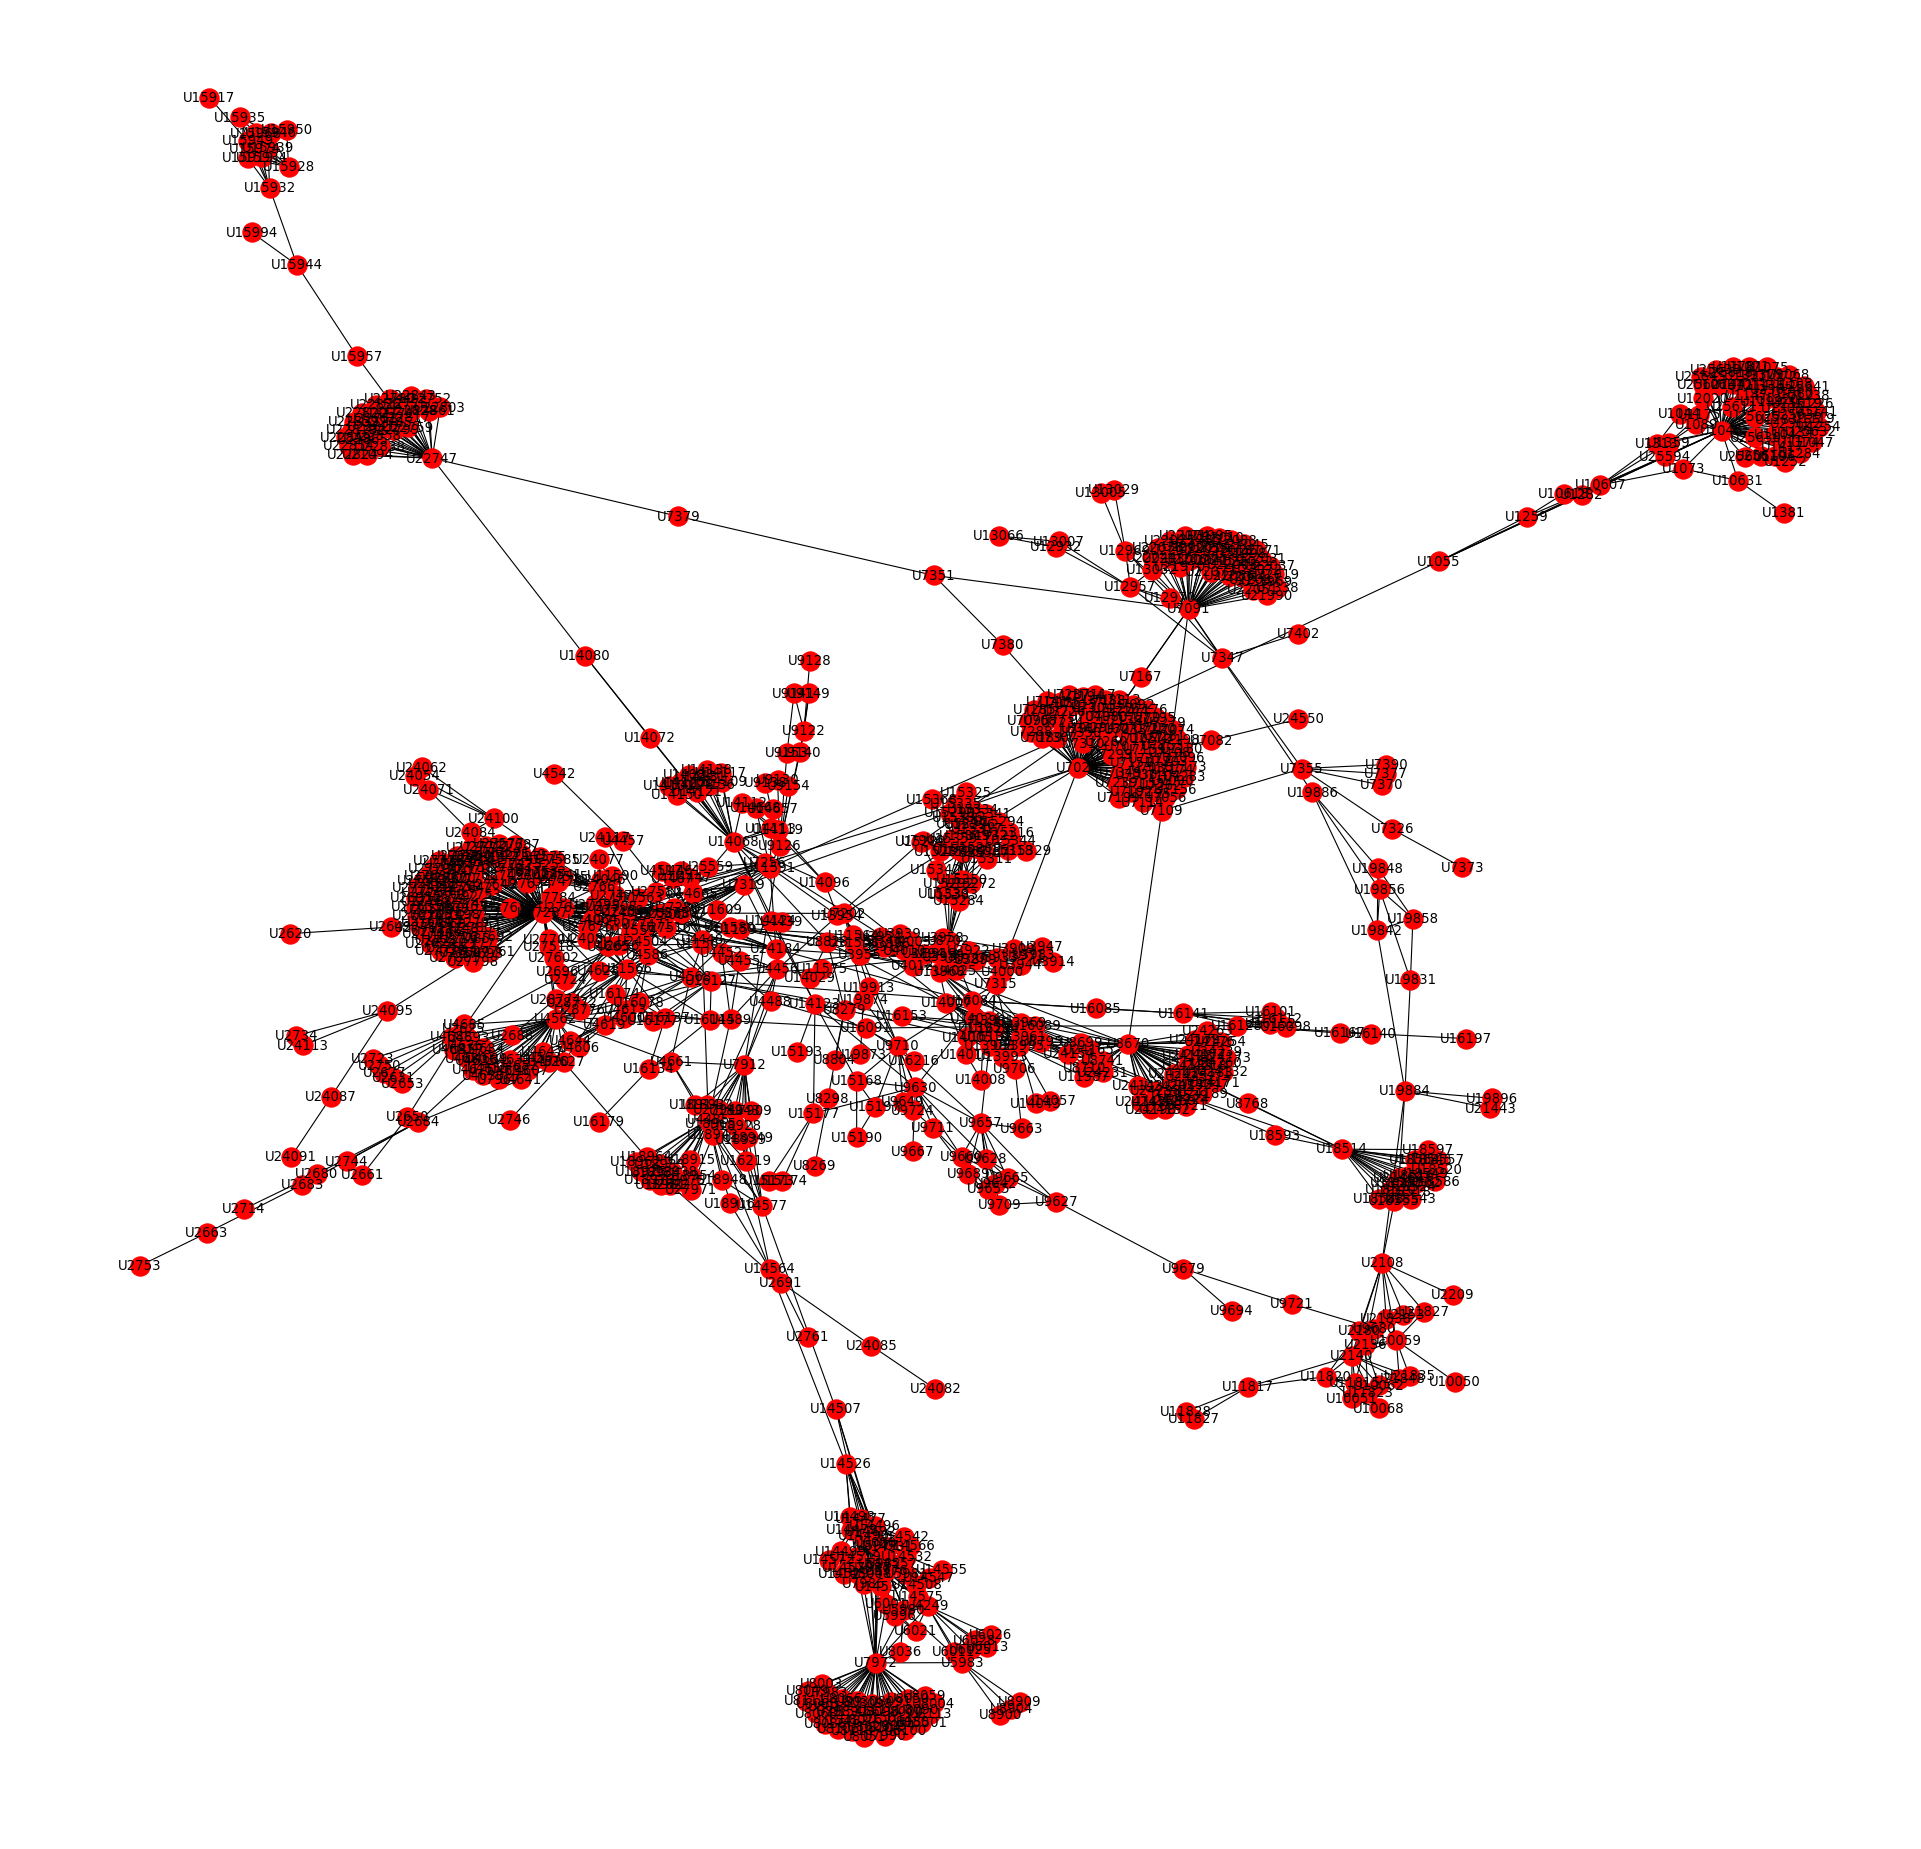

In [23]:
drawGraph(G,False)

In [29]:
def find_community(graph,k):
    return list(nx.algorithms.community.k_clique_communities(graph,k))


In [61]:
G1 = G
rst_com = find_community(G1,6)
rst_com = sorted(rst_com ,key = lambda t :len(t), reverse = True )
color = ['blue','y','g','pink','black']
for i in G1:
    G1.node[i]['color'] = 'r'
for i in range(5):
    for user in rst_com[i]:
        G1.node[user]['color'] = color[i%len(color)]       

In [65]:
def prediction_by_community(attr,empty_nodes,g,rst_com):
    predictions = {}
    for com in rst_com:
        empty_in_com = []
        prediction = {}
        for node in com:
            if node in empty_nodes:
                predictions[node]=[]
                empty_in_com.append(node)
        prediction = naive_method(attr,G1.subgraph(com),empty_in_com)
        for i,j in prediction.items():
            for k in j:
                predictions[i].append(k)
    return predictions
testCollege(prediction_by_community(college,empty_nodes,G1,rst_com))
testEmployer(prediction_by_community(employer,empty_nodes,G1,rst_com))
testLocation(prediction_by_community(location,empty_nodes,G1,rst_com))


 print the groudtruth rate for college_prediction
58.620690% of the predictions are true

 print the groudtruth rate for EmployerPrediction
27.586207% of the predictions are true

 print the groudtruth rate for location_prediction
48.275862% of the predictions are true


48.275862068965516

In [27]:
ast = nx.algorithms.assortativity.degree_assortativity_coefficient(G1.subgraph(rst_com[0]))
ast

-0.22118969769976082

In [28]:
import sys
import time

  
for k in range(3,7):
        print ("############# k值: %d ################" % k)
        start_time = time.clock()
        rst_com = find_community(G,k)
        end_time = time.clock()
        print ("计算耗时(秒)：%.3f" % (end_time-start_time))
        print ("生成的社区数：%d" % len(rst_com))
        print(rst_com)

############# k值: 3 ################
计算耗时(秒)：0.047
生成的社区数：51
[frozenset({'U4563', 'U27602', 'U16078', 'U24046', 'U11566', 'U4641', 'U4562', 'U4606', 'U16134', 'U27557', 'U3958', 'U3914', 'U27549', 'U4568', 'U27456', 'U27518', 'U27476', 'U3955', 'U7256', 'U27516', 'U4619', 'U27618', 'U11591', 'U11597', 'U4661', 'U3954', 'U4610', 'U24504', 'U4607', 'U27704', 'U4600', 'U4005', 'U27582', 'U4613', 'U11575', 'U27473', 'U3989', 'U24077', 'U27287', 'U27471', 'U2625', 'U3899', 'U3894', 'U27494', 'U16177', 'U14665', 'U27661', 'U16127', 'U2627', 'U11559', 'U27477', 'U27585', 'U4586', 'U27507', 'U27634', 'U24184', 'U3918', 'U27648', 'U27784', 'U27283', 'U3895', 'U27687', 'U3922', 'U4000', 'U16137', 'U25563', 'U7319', 'U27499', 'U3939', 'U24045', 'U3933', 'U4665', 'U27541', 'U3944', 'U4010', 'U16174', 'U11564', 'U4633', 'U11563', 'U4652', 'U24080', 'U4012', 'U2656', 'U27691', 'U3971', 'U4644', 'U3909', 'U16115', 'U4628', 'U11562', 'U27300', 'U7024', 'U27532', 'U27515', 'U3919', 'U27289', 'U27676', 